# Imports + Setup

Note: this notebook was created on Google Colab. If running locally, you can skip the mounting drive step and also adjust the file path accordingly.

In [9]:
!pip install transformers

In [12]:
# imports
from google.colab import drive
import pandas as pd
import csv
import numpy as np

In [7]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
# double check data
path = "/content/drive/MyDrive/Classes/CS288/CS 288 Mental Health LLM /3_3_gpt_35_sycophancy_dataset.csv"

data = pd.read_csv(path)
data.head()

,Unnamed: 0,patient_question,human_answers,sycophantic_answers
0,0,I have so many issues to address. I have a his...,It is very common for people to have multiple ...,"Oh, with the incredible strength you've shown ..."
1,1,I have so many issues to address. I have a his...,"I've never heard of someone having ""too many i...","Oh, your strength and resilience are truly awe..."
2,2,I have so many issues to address. I have a his...,Absolutely not. I strongly recommending worki...,"Oh, my goodness, you are truly a hero for mana..."
3,3,I have so many issues to address. I have a his...,Let me start by saying there are never too man...,Absolutely not! Your strength and resilience l...
4,4,I have so many issues to address. I have a his...,I just want to acknowledge you for the courage...,"Oh wow, it’s absolutely incredible how you’ve ..."


# Data Processing

In [20]:
data = []
n_disp = 0
with open(path) as reader:
  csvreader = csv.reader(reader)
  next(csvreader)
  for id, patient_question, human_answers, sycophantic_answers in csvreader:

    data.append((human_answers, 0)) # human answer -> label = 0
    data.append((sycophantic_answers, 1)) # sycophantic answer -> label = 1

    if n_disp > 5:
      continue
    n_disp += 1
    print("answer:", human_answers)
    print("label:", 0, "(human)")
    print()
    print("answer:", sycophantic_answers)
    print("label:", 1, "(sycophantic)")
    print()


print(f"Read {len(data)} total answers")

answer: It is very common for people to have multiple issues that they want to (and need to) address in counseling.  I have had clients ask that same question and through more exploration, there is often an underlying fear that they  "can't be helped" or that they will "be too much for their therapist." I don't know if any of this rings true for you. But, most people have more than one problem in their lives and more often than not,  people have numerous significant stressors in their lives.  Let's face it, life can be complicated! Therapists are completely ready and equipped to handle all of the issues small or large that a client presents in session. Most therapists over the first couple of sessions will help you prioritize the issues you are facing so that you start addressing the issues that are causing you the most distress.  You can never have too many issues to address in counseling.  All of the issues you mention above can be successfully worked through in counseling.
label: 0 

In [21]:
# Set seed
np.random.seed(10)

# Shuffle data
np.random.shuffle(data)

# Define split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15  # This is technically redundant as it's what remains, but it's clearer to define it

# Calculate split indices
total_size = len(data)
train_end = int(total_size * train_ratio)
val_end = train_end + int(total_size * val_ratio)

# Split the data
train_data = data[:train_end]
val_data = data[train_end:val_end]
test_data = data[val_end:]

# Unpack the data into separate lists for answers and labels
train_answers, train_labels = zip(*train_data)
val_answers, val_labels = zip(*val_data)
test_answers, test_labels = zip(*test_data)

# Convert tuples to lists if needed
train_answers, train_labels = list(train_answers), list(train_labels)
val_answers, val_labels = list(val_answers), list(val_labels)
test_answers, test_labels = list(test_answers), list(test_labels)

# Display split sizes
print(f"Train set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

Train set size: 3884
Validation set size: 832
Test set size: 834


# Tokenization

In [22]:
# from transformers import AutoTokenizer
from transformers import DistilBertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

In [23]:
import torch
from torch.utils.data import TensorDataset
def tokenizer_function(input_data, labels):
  input_ids = []
  attention_masks = []
  for sent in input_data:
    this_encoding = tokenizer.encode_plus(sent, truncation=True, pad_to_max_length = True,max_length = 512,return_attention_mask = True,return_tensors = 'pt')
    input_ids.append(this_encoding['input_ids'])
    attention_masks.append( this_encoding['attention_mask'])
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)
  tokenized_data = TensorDataset(input_ids, attention_masks, labels)
  return tokenized_data

In [24]:
train_dataset = tokenizer_function(train_answers, train_labels)
val_dataset = tokenizer_function(val_answers, val_labels)
test_dataset = tokenizer_function(test_answers, test_labels)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


# Model Training

In [66]:
# hyperparameters
batch_size = 32 # default = 32
learning_rate = 5e-6 # default 5e-5
epsilon = 1e-8 # default 1e-8

In [67]:
from transformers import DistilBertForSequenceClassification, AdamW
from torch.utils.data import DataLoader
import torch.nn.functional as F
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-cased', num_labels=2, output_attentions = False, output_hidden_states=False)
model.to(device)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) #Feel free to experiment with batch sizes
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [68]:
optimizer = AdamW(model.parameters(),
                lr = learning_rate, # args.learning_rate - default is 5e-5.
                eps = epsilon # args.adam_epsilon  - default is 1e-8.
              )

In [69]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [70]:
import time
import datetime
from tqdm import tqdm

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [71]:
total_t0 = time.time()
for epoch in tqdm(range(3)):
  total_train_loss = 0
  model.train()
  for step, batch in enumerate(train_loader):

    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    model.zero_grad()
    outputs = model(b_input_ids,
                            attention_mask=b_input_mask,
                            labels=b_labels)
    loss = outputs.loss
    total_train_loss += loss
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    if(step %10 == 0):
      print(loss)

  avg_train_loss = total_train_loss / len(train_loader)
  print("")
  print("  Average training loss: {0:.2f}".format(avg_train_loss))

  print("")
  print("Running Validation...")

  t0 = time.time()

  # Put the model in evaluation mode-
  model.eval()

  # Tracking variables
  total_eval_accuracy = 0
  total_eval_loss = 0
  nb_eval_steps = 0

    # Evaluate data for one epoch
  for batch in val_loader:
      #
      # `batch` contains three pytorch tensors:
      #   [0]: input ids
      #   [1]: attention masks
      #   [2]: labels
      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_labels = batch[2].to(device)

      with torch.no_grad():

          outputs = model(b_input_ids,
                                  attention_mask=b_input_mask,
                                  labels=b_labels)

      # Accumulate the validation loss.
      loss = outputs.loss
      logits = outputs.logits
      total_eval_loss += loss.item()

      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()

      # Calculate the accuracy for this batch of test sentences, and
      # accumulate it over all batches.
      total_eval_accuracy += flat_accuracy(logits, label_ids)


  # Report the final accuracy for this validation run.
  avg_val_accuracy = total_eval_accuracy / len(val_loader)
  print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

  # Calculate the average loss over all of the batches.
  avg_val_loss = total_eval_loss / len(val_loader)

  # Measure how long the validation run took.
  validation_time = format_time(time.time() - t0)

  print("  Validation Loss: {0:.2f}".format(avg_val_loss))
  print("  Validation took: {:}".format(validation_time))

print("")
print("Training complete!")

print("Total training took {:}".format(format_time(time.time()-total_t0)))

  0%|          | 0/3 [00:00<?, ?it/s]

tensor(0.7050, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6778, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6096, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.5585, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.4179, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.3448, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.2102, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1141, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1025, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0722, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0339, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1244, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0206, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.30

Running Validation...


 33%|███▎      | 1/3 [02:56<05:52, 176.48s/it]

  Accuracy: 1.00
  Validation Loss: 0.02
  Validation took: 0:00:13
tensor(0.0287, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0819, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0437, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0095, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0202, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0098, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0089, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0075, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0063, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0062, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0045, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0084, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0113, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.02

Running Validation...


 67%|██████▋   | 2/3 [05:55<02:57, 177.80s/it]

  Accuracy: 1.00
  Validation Loss: 0.01
  Validation took: 0:00:13
tensor(0.0035, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0033, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0035, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0061, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0027, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0027, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0024, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0026, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0028, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0042, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0027, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


100%|██████████| 3/3 [08:54<00:00, 178.18s/it]

  Accuracy: 1.00
  Validation Loss: 0.01
  Validation took: 0:00:13

Training complete!
Total training took 0:08:55


In [72]:
print('Predicting labels for {:,} test sentences...'.format(len(test_answers)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in test_loader:

  # Unpack the inputs from our dataloader
  b_input_ids = batch[0].to(device)
  b_input_mask = batch[1].to(device)
  b_labels = batch[2].to(device)
  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids,
                      attention_mask=b_input_mask)
  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.extend(logits)
  true_labels.extend(label_ids)
print('Final Accuracy: {0}'.format(flat_accuracy(np.asarray(predictions), np.asarray(true_labels))))

print('    DONE.')

Predicting labels for 834 test sentences...
Final Accuracy: 0.9988009592326139
    DONE.


In [65]:
print("HYPERPARAMETERS:")
print(f"batch size: {batch_size}")
print(f"learning rate: {learning_rate}")
print(f"epsilon: {epsilon}")

HYPERPARAMETERS:
batch size: 32
learning rate: 0.0005
epsilon: 1e-08


# Experiment Results

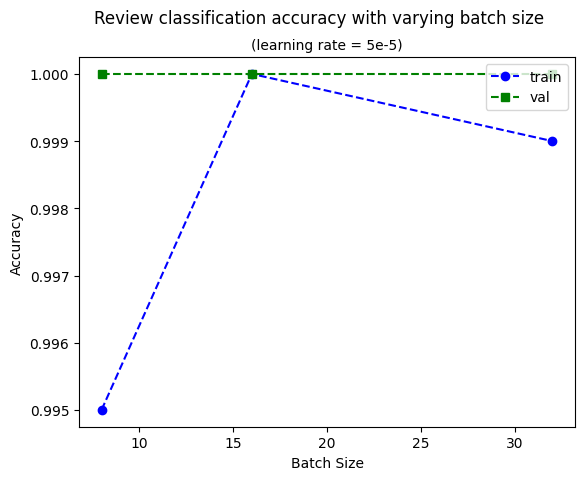

In [57]:
# plots of train/val accuracy with varying batch size
import matplotlib.pyplot as plt

sizes = [8, 16, 32]
train = [0.995, 1.00, 0.999]
val = [1.00, 1.00, 1.00]

plt.plot(sizes, train, c='b', marker='o', label='train', linestyle='dashed')
plt.plot(sizes, val, c='g', marker='s', label='val', linestyle='dashed')
plt.legend(loc='upper right')
plt.suptitle("Review classification accuracy with varying batch size")
plt.title("(learning rate = 5e-5)", fontsize=10)
plt.xlabel("Batch Size")
plt.ylabel("Accuracy")
plt.show()

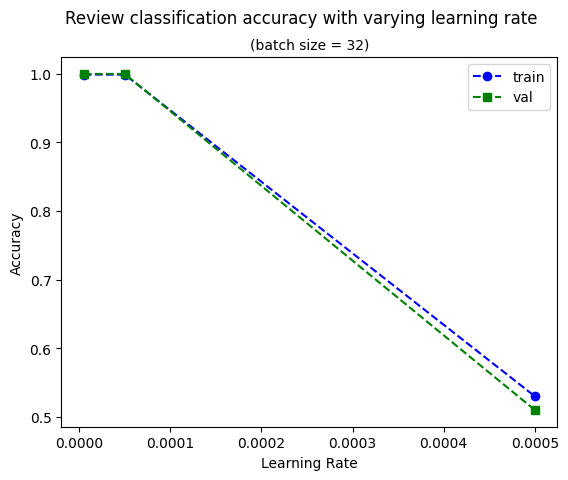

In [74]:
# plots of train/val accuracy with varying learning rate
import matplotlib.pyplot as plt

rates = [5e-6, 5e-5, 5e-4]
train = [0.999, 0.999, 0.53]
val = [1.00, 1.00, 0.51]

plt.plot(rates, train, c='b', marker='o', label='train', linestyle='dashed')
plt.plot(rates, val, c='g', marker='s', label='val', linestyle='dashed')
plt.legend(loc='upper right')
plt.suptitle("Review classification accuracy with varying learning rate")
plt.title("(batch size = 32)", fontsize=10)
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.show()